Naive Bayes - Average Cluster Completeness: 1.0
Naive Bayes - Average Cluster Homogeneity: 0.6808510638297872
Naive Bayes - Average V-measure: 0.6808510638297872
Naive Bayes - Average Cluster Purity: 0.7784575659564471
Fuzzy C-Means - Average Cluster Completeness: 0.6085446085549673
Fuzzy C-Means - Average Cluster Homogeneity: 0.8527083054151052
Fuzzy C-Means - Average V-measure: 0.5434780448870202
Fuzzy C-Means - Average Cluster Purity: 0.9278055363159176


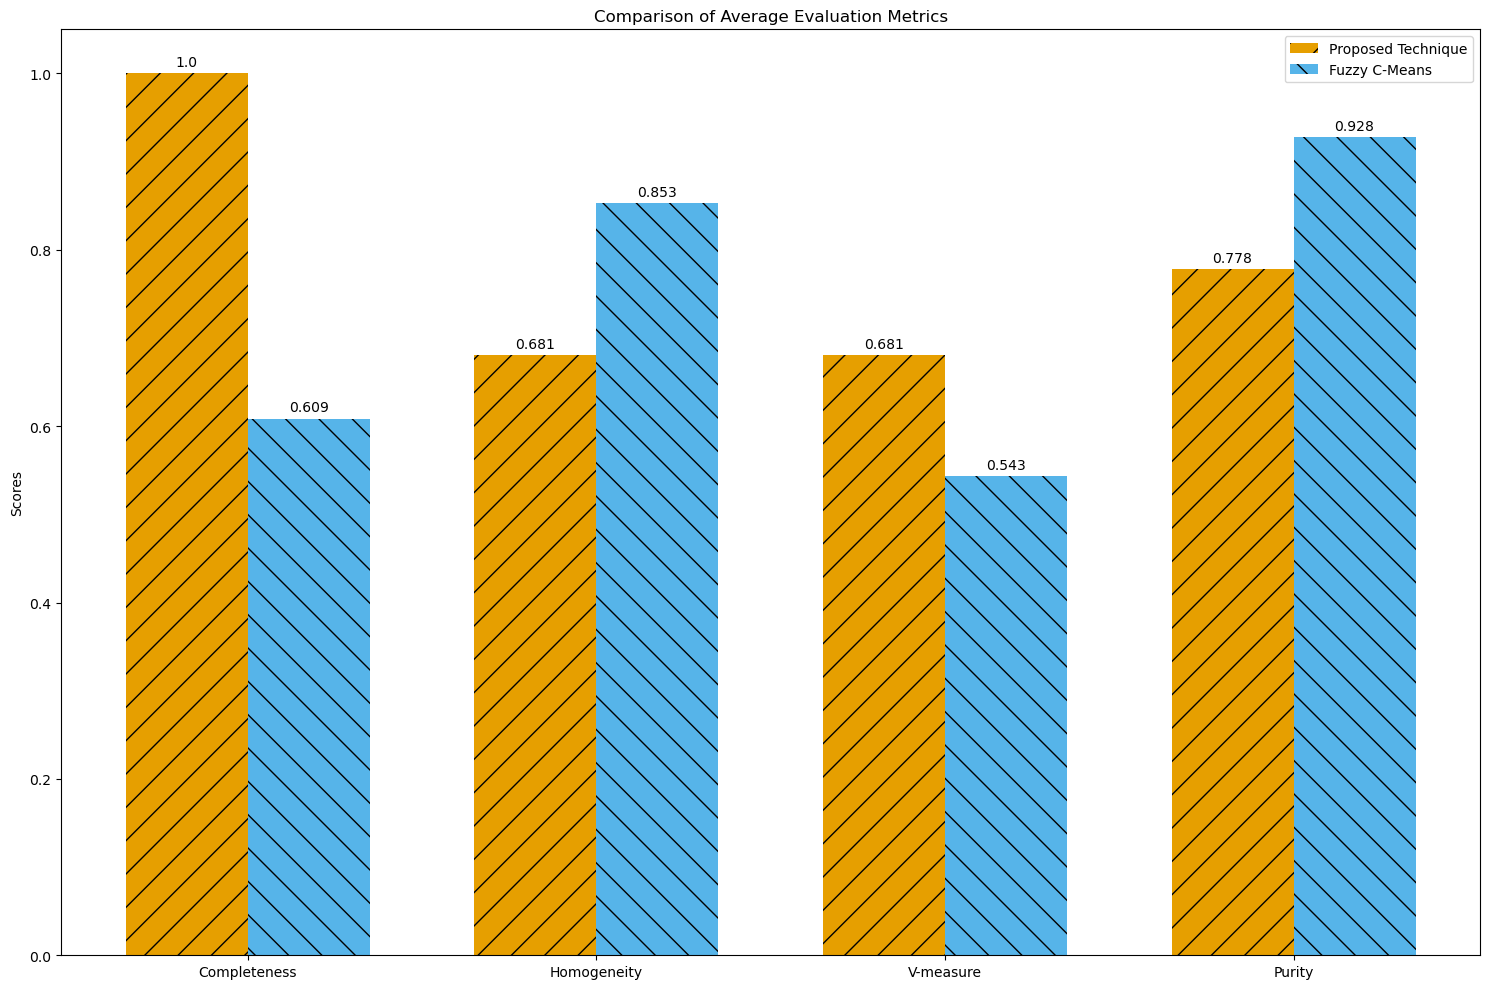

In [2]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score
from collections import Counter
from joblib import Parallel, delayed
import random

# Load the dataset
file_path = 'training_data.csv'  # Change this to the correct file path
df = pd.read_csv(file_path)

# Drop unnecessary columns
df.drop(columns=['fluid_overload', 'fluid_overload.1'], inplace=True)

# Extract symptoms data and the true labels
symptoms_data = df.drop(columns=['prognosis'])
true_labels = df['prognosis']

# Convert the DataFrame to a numpy array
symptoms_data_array = symptoms_data.to_numpy()

# Define the number of clusters (diseases)
diseases = df['prognosis'].unique()
num_clusters = len(diseases)

# Perform Fuzzy C-Means clustering on the entire dataset
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    symptoms_data_array.T, num_clusters, 2, error=0.005, maxiter=1000, init=None)

# Output the membership values for each symptom in each cluster
membership_values = u.T

# Function to calculate cluster purity
def cluster_purity(true_labels, predicted_labels):
    cluster_purities = []
    for cluster_idx in set(predicted_labels):
        cluster_true_labels = [true_labels[i] for i in range(len(predicted_labels)) if predicted_labels[i] == cluster_idx]
        cluster_counter = Counter(cluster_true_labels)
        majority_class_count = cluster_counter.most_common(1)[0][1]
        cluster_purity = majority_class_count / len(cluster_true_labels)
        cluster_purities.append(cluster_purity)
    return sum(cluster_purities) / len(set(predicted_labels))

# Function to evaluate a single combination for Naive Bayes
def evaluate_combination_naive_bayes(evidence_symptoms):
    # Filter the dataset based on the current combination of evidence symptoms
    query = np.logical_and.reduce([df[symptom] == 1 for symptom in evidence_symptoms])
    filtered_df = df[query]

    # Skip if the filtered dataframe is empty
    if filtered_df.empty:
        return None

    # Extract true labels from the filtered dataset
    true_labels = filtered_df['prognosis'].values

    # Generate predicted labels based on the Naive Bayes formula
    predicted_labels = []
    for idx, row in filtered_df.iterrows():
        results = {}
        sum_prob = 0.0
        for disease in joint_probabilities:
            query_prob = joint_probabilities[disease]
            valid_symptoms = {
                symptom: output_dict[disease][symptom]
                for symptom in evidence_symptoms if symptom in output_dict[disease] and output_dict[disease][symptom] != 0
            }
            if valid_symptoms:
                for symptom, symptom_prob in valid_symptoms.items():
                    query_prob *= symptom_prob
                results[disease] = query_prob
                sum_prob += query_prob
        
        # Normalize the probabilities for diseases
        for disease, probability in results.items():
            results[disease] = probability / sum_prob
        
        # Choose the predicted label with the highest posterior probability
        predicted_label = max(results, key=results.get)
        predicted_labels.append(predicted_label)

    # Calculate evaluation metrics for the current combination
    completeness = completeness_score(true_labels, predicted_labels)
    homogeneity = homogeneity_score(true_labels, predicted_labels)
    v_measure = v_measure_score(true_labels, predicted_labels)
    purity = cluster_purity(true_labels, predicted_labels)

    return completeness, homogeneity, v_measure, purity

# Function to evaluate a single combination for Fuzzy C-Means
def evaluate_combination_fuzzy_cmeans(evidence_symptoms):
    # Filter the dataset based on the current combination of evidence symptoms
    query = np.logical_and.reduce([df[symptom] == 1 for symptom in evidence_symptoms])
    filtered_df = df[query]

    # Skip if the filtered dataframe is empty
    if filtered_df.empty:
        return None

    # Extract true labels from the filtered dataset
    true_labels = filtered_df['prognosis'].values

    # Use the clustering result on the filtered dataset
    filtered_indices = filtered_df.index
    filtered_membership_values = membership_values[filtered_indices]

    # Assign each data point to the cluster with the highest membership value
    predicted_labels = np.argmax(filtered_membership_values, axis=1)

    # Map predicted labels to disease names
    predicted_disease_labels = np.array([diseases[label] for label in predicted_labels])

    # Calculate evaluation metrics for the current combination
    completeness = completeness_score(true_labels, predicted_disease_labels)
    homogeneity = homogeneity_score(true_labels, predicted_disease_labels)
    v_measure = v_measure_score(true_labels, predicted_disease_labels)
    purity = cluster_purity(true_labels, predicted_disease_labels)

    return completeness, homogeneity, v_measure, purity

# Calculate joint and conditional probabilities for Naive Bayes
joint_probabilities = {}
for disease in diseases:
    disease_data = df[df['prognosis'] == disease].drop(columns=['prognosis'])
    joint_prob = disease_data.sum().sum() / df.drop(columns=['prognosis']).sum().sum()
    joint_probabilities[disease] = joint_prob

total_counts = df.drop(columns=['prognosis']).sum(axis=0)
p_Symptom_given_Disease = {}
for disease in diseases:
    disease_data = df[df['prognosis'] == disease].drop(columns=['prognosis'])
    p_Symptom_given_Disease[disease] = {}
    for symptom in disease_data.columns:
        if total_counts[symptom] != 0:
            p_Symptom_given_Disease[disease][symptom] = disease_data[symptom].sum() / total_counts[symptom]

# Convert to the desired dictionary format
output_dict = {}
for disease in diseases:
    output_dict[disease] = p_Symptom_given_Disease[disease]

# Function to generate random combinations of symptoms
def generate_random_combination(symptoms, max_length):
    length = random.randint(1, max_length)
    return random.sample(list(symptoms), length)

# Parameters for sampling
sample_size = 1000  # Total number of combinations to sample
max_comb_length = 5  # Maximum length of combinations to consider

# Generate random combinations of symptoms
random.seed(42)  # For reproducibility
combinations = [generate_random_combination(symptoms_data.columns, max_comb_length) for _ in range(sample_size)]

# Evaluate combinations in parallel for Naive Bayes
results_naive_bayes = Parallel(n_jobs=-1)(delayed(evaluate_combination_naive_bayes)(comb) for comb in combinations)

# Evaluate combinations in parallel for Fuzzy C-Means
results_fuzzy_cmeans = Parallel(n_jobs=-1)(delayed(evaluate_combination_fuzzy_cmeans)(comb) for comb in combinations)

# Filter out None results
results_naive_bayes = [res for res in results_naive_bayes if res is not None]
results_fuzzy_cmeans = [res for res in results_fuzzy_cmeans if res is not None]

# Separate the results into individual lists for Naive Bayes
completeness_scores_nb, homogeneity_scores_nb, v_measure_scores_nb, purity_scores_nb = zip(*results_naive_bayes)

# Separate the results into individual lists for Fuzzy C-Means
completeness_scores_fc, homogeneity_scores_fc, v_measure_scores_fc, purity_scores_fc = zip(*results_fuzzy_cmeans)

# Calculate the average evaluation metrics for Naive Bayes
avg_completeness_nb = np.mean(completeness_scores_nb)
avg_homogeneity_nb = np.mean(homogeneity_scores_nb)
avg_v_measure_nb = np.mean(v_measure_scores_nb)
avg_purity_nb = np.mean(purity_scores_nb)

# Calculate the average evaluation metrics for Fuzzy C-Means
avg_completeness_fc = np.mean(completeness_scores_fc)
avg_homogeneity_fc = np.mean(homogeneity_scores_fc)
avg_v_measure_fc = np.mean(v_measure_scores_fc)
avg_purity_fc = np.mean(purity_scores_fc)

# Print the average evaluation metrics across all combinations for Naive Bayes
print("Naive Bayes - Average Cluster Completeness:", avg_completeness_nb)
print("Naive Bayes - Average Cluster Homogeneity:", avg_homogeneity_nb)
print("Naive Bayes - Average V-measure:", avg_v_measure_nb)
print("Naive Bayes - Average Cluster Purity:", avg_purity_nb)

# Print the average evaluation metrics across all combinations for Fuzzy C-Means
print("Fuzzy C-Means - Average Cluster Completeness:", avg_completeness_fc)
print("Fuzzy C-Means - Average Cluster Homogeneity:", avg_homogeneity_fc)
print("Fuzzy C-Means - Average V-measure:", avg_v_measure_fc)
print("Fuzzy C-Means - Average Cluster Purity:", avg_purity_fc)

# Generate a bar graph for the average evaluation metrics
metrics = ['Completeness', 'Homogeneity', 'V-measure', 'Purity']
avg_scores_nb = [avg_completeness_nb, avg_homogeneity_nb, avg_v_measure_nb, avg_purity_nb]
avg_scores_fc = [avg_completeness_fc, avg_homogeneity_fc, avg_v_measure_fc, avg_purity_fc]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 10))  # Increase the figure size to ensure width/height > 3000px
colors = ['#E69F00', '#56B4E9']  # Use colorblind-friendly colors
hatches = ['/', '\\']  # Hatching patterns for bars
rects1 = ax.bar(x - width/2, avg_scores_nb, width, label='Proposed Technique', color=colors[0], hatch=hatches[0])
rects2 = ax.bar(x + width/2, avg_scores_fc, width, label='Fuzzy C-Means', color=colors[1], hatch=hatches[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of Average Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
